In [1]:
import os
import warnings
warnings.filterwarnings(action='ignore')

if os.getcwd() == '/content':
    data_path = '/content/drive/MyDrive/Colab Notebooks/datasets'
else:
    data_path = r'G:\내 드라이브\Colab Notebooks\datasets'

# Loss Function

## pytorch(low-level)

In [2]:
import torch
import torch.nn.functional as F

torch.manual_seed(1)

In [3]:
z = torch.FloatTensor([1, 2, 3])
print(z.shape)
print(z)

hypothesis = F.softmax(z, dim=0)
print(hypothesis, hypothesis.sum())

torch.Size([3])
tensor([1., 2., 3.])
tensor([0.0900, 0.2447, 0.6652]) tensor(1.)


In [4]:
z = torch.rand(3, 5, requires_grad=True)
print(z.shape)
print(z)

hypothesis = F.softmax(z, dim=1) # sample(row)
print(hypothesis)
print(hypothesis.sum(dim=1))

torch.Size([3, 5])
tensor([[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
        [0.7999, 0.3971, 0.7544, 0.5695, 0.4388],
        [0.6387, 0.5247, 0.6826, 0.3051, 0.4635]], requires_grad=True)
tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)
tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


In [5]:
y = torch.randint(5, (3, )).long()
y

tensor([0, 2, 1])

In [6]:
y_oh = torch.zeros_like(hypothesis)
print(y_oh)

print(y.unsqueeze(1))
y_oh.scatter_(dim=1, index=y.unsqueeze(1), value=1)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[0],
        [2],
        [1]])


tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [7]:
cost = (y_oh * -torch.log(hypothesis)).sum(dim=1).mean()
cost

tensor(1.4689, grad_fn=<MeanBackward0>)

## pytorch(high-level)

### F.softmax() + torch.log() = F.log_softmax()

In [8]:
torch.log(F.softmax(z, dim=1))

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward0>)

In [9]:
F.log_softmax(z, dim=1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

### F.log_softmax() + F.nll_loss() = F.cross_entropy()

In [10]:
(y_oh * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [11]:
(y_oh * - F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [12]:
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

# Softmax Regression Implementation

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [14]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

x_train.shape, y_train.shape

(torch.Size([8, 4]), torch.Size([8]))

## low-level

In [15]:
y_oh = torch.zeros(8, 3)
y_oh.scatter_(dim=1, index=y_train.unsqueeze(1), value=1)
y_oh.shape

torch.Size([8, 3])

In [16]:
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
optimizer = optim.SGD([W, b], lr=0.1)

epochs = 1000
for epoch in range(epochs + 1):
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1)
    cost = (y_oh * -torch.log(hypothesis)).sum(dim=1).mean()
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'[epoch {epoch:4d}/{epochs}] cost: {cost.item():.6f}')

[epoch    0/1000] cost: 1.098612
[epoch  100/1000] cost: 0.761050
[epoch  200/1000] cost: 0.689991
[epoch  300/1000] cost: 0.643229
[epoch  400/1000] cost: 0.604117
[epoch  500/1000] cost: 0.568255
[epoch  600/1000] cost: 0.533922
[epoch  700/1000] cost: 0.500291
[epoch  800/1000] cost: 0.466908
[epoch  900/1000] cost: 0.433507
[epoch 1000/1000] cost: 0.399962


## high-level

In [17]:
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = optim.SGD([W, b], lr=0.1)
epochs = 1000
for epoch in range(epochs + 1):
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'[epoch {epoch:4d}/{epochs}] cost: {cost.item():.6f}')

[epoch    0/1000] cost: 1.098612
[epoch  100/1000] cost: 0.761050
[epoch  200/1000] cost: 0.689991
[epoch  300/1000] cost: 0.643229
[epoch  400/1000] cost: 0.604117
[epoch  500/1000] cost: 0.568255
[epoch  600/1000] cost: 0.533922
[epoch  700/1000] cost: 0.500291
[epoch  800/1000] cost: 0.466908
[epoch  900/1000] cost: 0.433507
[epoch 1000/1000] cost: 0.399962


## nn.Module

In [18]:
model = nn.Linear(in_features=4, out_features=3)
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 1000
for epoch in range(epochs + 1):
    pred = model(x_train)
    cost = F.cross_entropy(pred, y_train)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'[epoch {epoch:4d}/{epochs}] cost: {cost.item():.6f}')

[epoch    0/1000] cost: 1.616785
[epoch  100/1000] cost: 0.658891
[epoch  200/1000] cost: 0.573443
[epoch  300/1000] cost: 0.518151
[epoch  400/1000] cost: 0.473265
[epoch  500/1000] cost: 0.433516
[epoch  600/1000] cost: 0.396563
[epoch  700/1000] cost: 0.360914
[epoch  800/1000] cost: 0.325392
[epoch  900/1000] cost: 0.289178
[epoch 1000/1000] cost: 0.254148


## Class

In [19]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=4, out_features=3)
    
    def forward(self, x):
        return self.linear(x)

In [20]:
model = SoftmaxClassifierModel()
optimizer = optim.SGD(model.parameters(), lr=0.1)

epoch = 1000
for epoch in range(epochs + 1):
    pred = model(x_train)
    cost = F.cross_entropy(pred, y_train)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'[epoch {epoch:4d}/{epochs}] cost: {cost.item():.6f}')

[epoch    0/1000] cost: 2.637636
[epoch  100/1000] cost: 0.647903
[epoch  200/1000] cost: 0.564643
[epoch  300/1000] cost: 0.511043
[epoch  400/1000] cost: 0.467249
[epoch  500/1000] cost: 0.428280
[epoch  600/1000] cost: 0.391924
[epoch  700/1000] cost: 0.356742
[epoch  800/1000] cost: 0.321577
[epoch  900/1000] cost: 0.285617
[epoch 1000/1000] cost: 0.250818


# MNIST classification

In [21]:
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)

In [24]:
training_epochs = 10
batch_size = 100

In [25]:
mnist_train = datasets.MNIST(root=data_path,
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)

mnist_test = datasets.MNIST(root=data_path,
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)

In [26]:
mnist_train[0][0].shape, mnist_train[0][1]

(torch.Size([1, 28, 28]), 5)

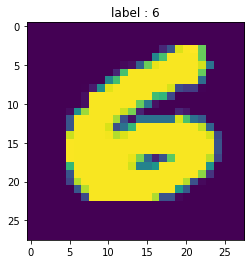

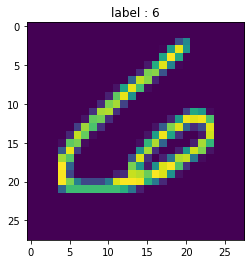

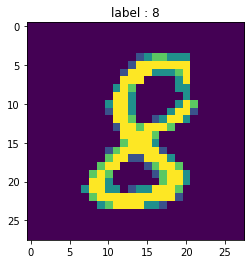

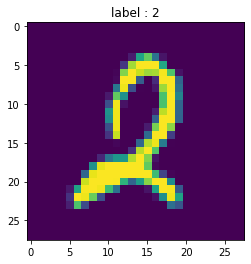

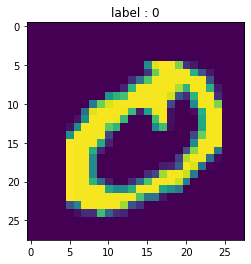

In [27]:
samples = torch.randint(low=0, high=len(mnist_train), size=(5, ))

for i in samples:
    plt.imshow(mnist_train[i][0].reshape(28, 28, -1))
    plt.title(f'label : {mnist_train[i][1]}')
    plt.show()

In [28]:
data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True, # mini batch shuffle
                         drop_last=True) # drop last remains

In [29]:
len(data_loader) # total_batch 600 * batch_size 100 = 60000

600

In [30]:
x, y = next(iter(data_loader))
x.shape, y.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

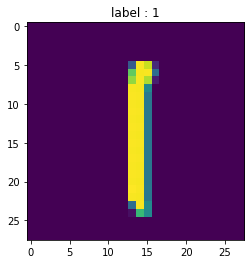

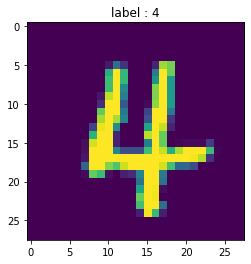

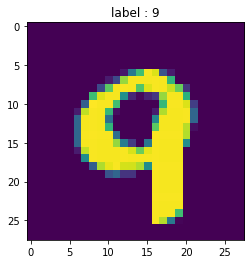

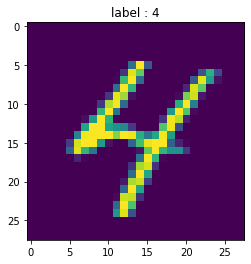

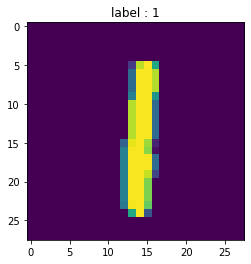

In [31]:
samples = torch.randint(low=0, high=100, size=(5, ))

for i in samples:
    plt.imshow(x.permute(0, 2, 3, 1)[i])
    plt.title(f'label : {y[i]}')
    plt.show()

In [32]:
model = nn.Linear(28*28, 10, bias=True).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(training_epochs):
    avg_loss = 0
    size = len(data_loader.dataset)
    num_batchs = len(data_loader)
    
    print(f'[epoch {epoch+1:>2d}/{training_epochs}]')
    
    for batch, (x, y) in enumerate(data_loader):
        x = x.view(-1, 28*28).to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if batch % 200 == 0:
            batch_loss, current = loss.item(), batch * len(x)
            print(f'loss : {batch_loss:>7f} [{current:>5d}/{size:>5d}]')
        
        avg_loss += loss / num_batchs
    
    print(f'epoch avg loss : {avg_loss:>8f}\n------------------------------\n')

print('Train finished')

[epoch  1/10]
loss : 2.321297 [    0/60000]
loss : 0.563212 [20000/60000]
loss : 0.356262 [40000/60000]
epoch avg loss : 0.535090
------------------------------

[epoch  2/10]
loss : 0.439047 [    0/60000]
loss : 0.292049 [20000/60000]
loss : 0.279400 [40000/60000]
epoch avg loss : 0.359095
------------------------------

[epoch  3/10]
loss : 0.405958 [    0/60000]
loss : 0.352463 [20000/60000]
loss : 0.344324 [40000/60000]
epoch avg loss : 0.331125
------------------------------

[epoch  4/10]
loss : 0.348626 [    0/60000]
loss : 0.339325 [20000/60000]
loss : 0.406891 [40000/60000]
epoch avg loss : 0.316358
------------------------------

[epoch  5/10]
loss : 0.373248 [    0/60000]
loss : 0.249942 [20000/60000]
loss : 0.186031 [40000/60000]
epoch avg loss : 0.306761
------------------------------

[epoch  6/10]
loss : 0.298238 [    0/60000]
loss : 0.359375 [20000/60000]
loss : 0.217830 [40000/60000]
epoch avg loss : 0.300266
------------------------------

[epoch  7/10]
loss : 0.27787

accuracy : 0.8873999714851379
label : 2
pred : 2


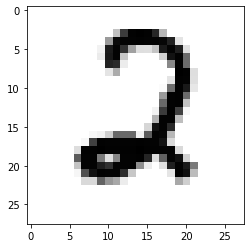

In [33]:
with torch.no_grad():
    x_test = mnist_test.test_data.view(-1, 28*28).float().to(device)
    y_test = mnist_test.test_labels.to(device)
    
    pred = model(x_test)
    # correct = torch.argmax(pred, dim=1) == y_test
    correct = pred.argmax(dim=1) == y_test
    accuracy = correct.float().mean()
    
    print(f'accuracy : {accuracy.item()}')
    
    r = torch.randint(low=0, high=len(mnist_test) - 1, size=(1, ))
    
    x_sample = mnist_test.test_data[r:r+1].view(-1, 28*28).float().to(device)
    y_sample = mnist_test.test_labels[r:r+1].to(device)
    
    print(f'label : {y_sample.item()}')
    
    sample_prediction = model(x_sample)
    print(f'pred : {torch.argmax(sample_prediction, dim=1).item()}')
    
    plt.imshow(mnist_test.test_data[r:r+1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()